<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/tarea8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 8

In [1]:
%%capture
!pip -q install scikit-learn pillow tqdm seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from PIL import Image
import os, glob, math, sys, gc, time

SEED = 42
rng = np.random.default_rng(SEED)

np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_colwidth', 140)

Setup listo.


In [3]:
try:
    mnist = fetch_openml("mnist_784", version=1, as_frame=False, parser="auto")
    X = mnist["data"].astype(np.float32)      # (70000, 784)
    y = mnist["target"].astype(int)           # (70000,)
except Exception as e:
    print("OpenML falló, usando keras.datasets.mnist:", e)
    from tensorflow.keras.datasets import mnist as keras_mnist
    (xtr, ytr), (xte, yte) = keras_mnist.load_data()
    X = np.vstack([xtr.reshape(-1,784), xte.reshape(-1,784)]).astype(np.float32)
    y = np.hstack([ytr, yte]).astype(int)

print("X shape:", X.shape, "y shape:", y.shape, "clases:", np.unique(y))
X /= 255.0


X shape: (70000, 784) y shape: (70000,) clases: [0 1 2 3 4 5 6 7 8 9]


In [4]:
def ver_digitos(X, y, etiqueta=None, n=9):
    idxs = np.arange(len(X)) if etiqueta is None else np.where(y==etiqueta)[0]
    idxs = idxs[:n]
    filas = int(math.ceil(n/3))
    fig, axes = plt.subplots(filas, 3, figsize=(6, 6))
    axes = axes.flatten()
    for i, ax in enumerate(axes[:len(idxs)]):
        ax.imshow(X[idxs[i]].reshape(28,28), cmap="gray")
        ax.set_axis_off()
    plt.suptitle(f"Ejemplos etiqueta={etiqueta}" if etiqueta is not None else "Ejemplos aleatorios")
    plt.tight_layout()
    plt.show()


In [14]:
from collections import defaultdict

def entrenar_rf(X_train, y_train, n_estimators=120, max_depth=None, random_state=SEED):
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        n_jobs=-1,
        random_state=random_state,
        class_weight="balanced_subsample",
        oob_score=False
    )
    rf.fit(X_train, y_train)
    return rf

def indices_par(y, a, b):
    return np.where((y==a) | (y==b))[0]

def tomar_submuestra(idxs, frac=1.0, rng=rng):
    if frac >= 1.0:
        return idxs
    n = max(50, int(len(idxs) * frac))
    return rng.choice(idxs, size=n, replace=False)

def importancias_por_digito_via_pares(X, y, test_size=1/7, frac_por_par=0.2, n_estimators=120):

    n_features = X.shape[1]
    suma = np.zeros((10, n_features), dtype=np.float64)
    cuenta = np.zeros(10, dtype=int)
    resultados = []  # (a,b,acc_test,n_train,n_test)

    for a in range(10):
        for b in range(a+1, 10):
            idxs = indices_par(y, a, b)
            idxs = tomar_submuestra(idxs, frac=frac_por_par, rng=rng)
            X_ab, y_ab = X[idxs], y[idxs]

            Xtr, Xte, ytr, yte = train_test_split(
                X_ab, y_ab, test_size=test_size, random_state=SEED, stratify=y_ab
            )
            rf = entrenar_rf(Xtr, ytr, n_estimators=n_estimators)
            imp = rf.feature_importances_.astype(np.float64)

            # Acumula a ambos dígitos
            suma[a] += imp; suma[b] += imp
            cuenta[a] += 1;  cuenta[b] += 1

            acc = accuracy_score(yte, rf.predict(Xte))
            resultados.append((a, b, acc, len(Xtr), len(Xte)))

    # Promedio por dígito (cada uno tiene 9 contribuciones)
    prom = (suma.T / np.maximum(cuenta, 1)).T
    return prom, pd.DataFrame(resultados, columns=["a","b","acc_test","n_train","n_test"])

TEST_SIZE = 1/7
FRAC_POR_PAR = 1
N_ESTIMATORS_PAIR = 120


In [15]:
imp_por_digito, resumen_pares = importancias_por_digito_via_pares(
    X, y, test_size=TEST_SIZE, frac_por_par=FRAC_POR_PAR, n_estimators=N_ESTIMATORS_PAIR
)
print("Resultados por par :")
display(resumen_pares.head())


Resultados por par :


,a,b,acc_test,n_train,n_test
0,0,1,0.999053,12668,2112
1,0,2,0.995466,11908,1985
2,0,3,0.997010,12037,2007
3,0,4,0.996430,11766,1961
4,0,5,0.997881,11328,1888


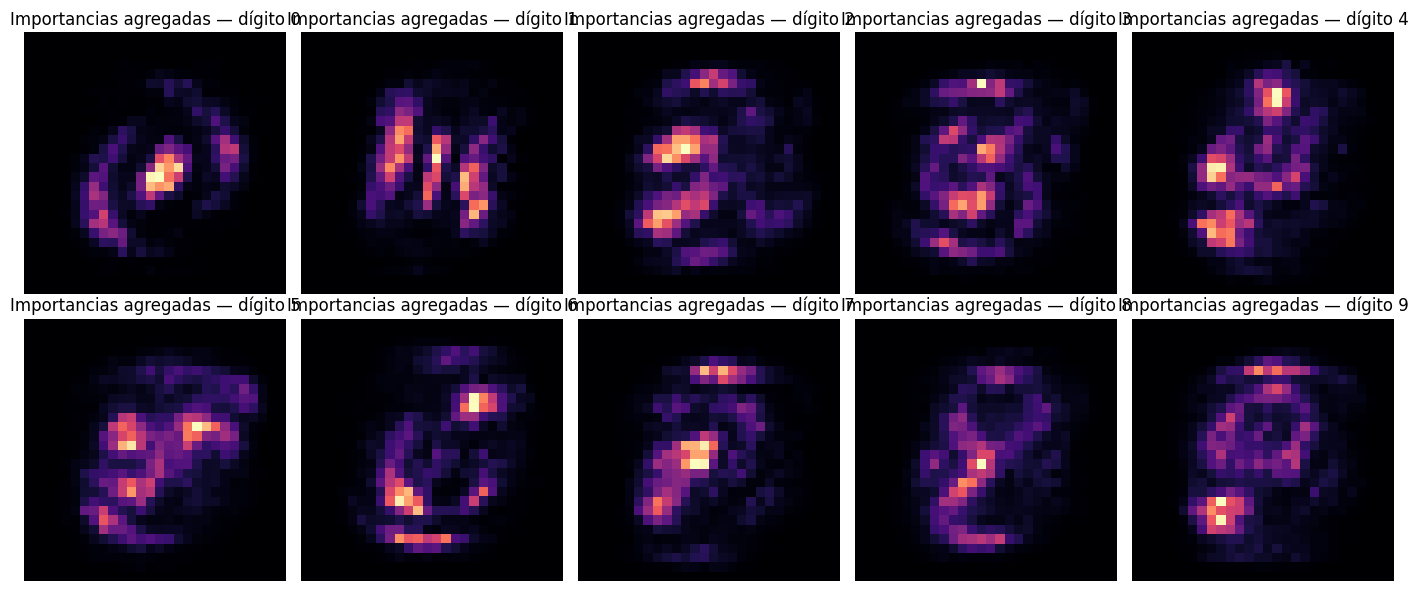

Archivo guardado: importancias_agregadas_por_digito.csv


In [16]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()
for d in range(10):
    ax = axes[d]
    ax.imshow(imp_por_digito[d].reshape(28,28), cmap="magma")
    ax.set_title(f"Importancias agregadas — dígito {d}")
    ax.set_axis_off()
plt.tight_layout()
plt.show()

df_imp = pd.DataFrame(imp_por_digito, index=[f"digito_{d}" for d in range(10)])
df_imp.to_csv("importancias_agregadas_por_digito.csv", index=True)
print("Archivo guardado:", "importancias_agregadas_por_digito.csv")


In [17]:
TEST_SIZE_FULL = 10000 / len(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE_FULL, random_state=SEED, stratify=y
)
print("Shapes:", X_train.shape, X_test.shape)

RF_TREES_FULL = 300
rf_full = RandomForestClassifier(
    n_estimators=RF_TREES_FULL,
    max_depth=None,
    n_jobs=-1,
    random_state=SEED,
    class_weight="balanced_subsample"
)
rf_full.fit(X_train, y_train)
y_pred = rf_full.predict(X_test)
acc_full = accuracy_score(y_test, y_pred)
print(f"Precisión (test, 10k): {acc_full:.4f}")


Shapes: (60000, 784) (10000, 784)
Precisión (test, 10k): 0.9692


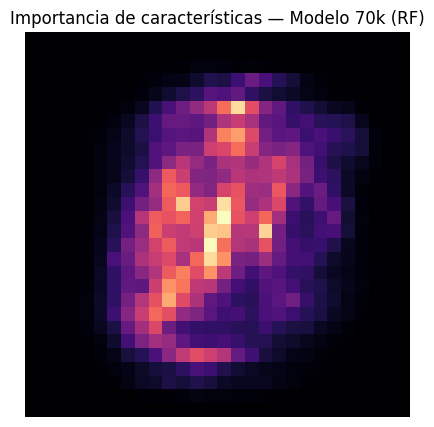

In [18]:
imp_full = rf_full.feature_importances_
plt.figure(figsize=(5,5))
plt.imshow(imp_full.reshape(28,28), cmap="magma")
plt.title("Importancia de características — Modelo 70k (RF)")
plt.axis("off")
plt.show()


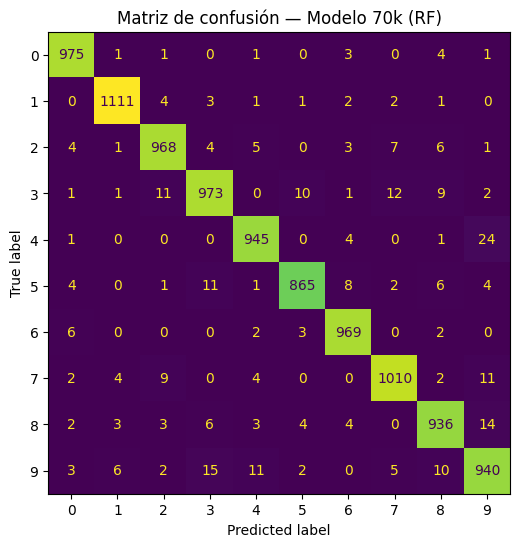

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, values_format="d", colorbar=False)
plt.title("Matriz de confusión — Modelo 70k (RF)")
plt.show()


- **Enunciado 1:** ¿Qué patrones ves en los heatmaps por dígito? ¿Qué regiones del 28×28 son más relevantes?  

- **Enunciado 2:** ¿Qué preprocesos ayudan (centrado, margen, suavizado)? ¿Cómo varía la confianza?


En el **Enunciado 1**, los heatmaps agregados por dígito muestran plantillas muy consistentes con la forma de cada número: el **0** resalta como un anillo uniforme con el centro poco relevante; el **1** concentra peso en la columna central y su base; el **2** marca el arco superior izquierdo, el trazo medio y la cola inferior derecha; el **3** se manifiesta con tres lóbulos en el costado derecho; el **4** enfatiza el cruce entre barra horizontal y trazo vertical, junto con la diagonal superior izquierda; el **5** combina barra superior izquierda y remate curvo inferior; el **6** destaca el lazo inferior con cierre hacia el centro; el **7** prioriza la barra superior y la diagonal derecha; el **8** ilumina ambos lazos con picos en los “cuellos”; y el **9** subraya el lazo superior y el descenso por el lado derecho. En general, las esquinas y bordes externos quedan con baja importancia salvo que el trazo llegue hasta ahí.

Para el **modelo entrenado con los 70 000 ejemplos** (división 60 000/10 000), el Bosque Aleatorio alcanzó una **precisión de 0.9692** en el conjunto de prueba. La matriz de confusión concentra los errores en pares morfológicamente cercanos: **4–9** (cuando el lazo del 9 no se cierra o el 4 se prolonga abajo), **3–5** (dos curvas en el costado derecho con remates parecidos), y confusiones puntuales de **8** con **9** o **3** si el estrechamiento central del 8 es débil. También aparece algo de **7–1** ante inclinaciones o “pies” pronunciados. El resto de las clases mantiene una diagonal dominante, lo que indica buena generalización.

En el **Enunciado 2**, para clasificar dígitos escritos por mí, los preprocesos que más ayudan son: **centrado por centroide** y **escalado** para ocupar ~20–24 píxeles de alto con **2–4 píxeles** de margen; **normalizar la polaridad** (invertir si el fondo es claro); aplicar **deskew** por momentos para corregir inclinación (especialmente útil en 1, 7 y 9); y un **suavizado mediana 3×3** si hay ruido de captura, evitando difuminar en exceso. Cuando el grosor del trazo difiere mucho del de MNIST, una **morfología ligera** (dilatación o erosión de un paso) armoniza la apariencia. Tras estos ajustes, la **confianza** del modelo (probabilidad máxima) tiende a subir y la segunda mejor a bajar, con mejoras notables en dígitos propensos a sesgo o desplazamiento.
